In [1]:
import sys
sys.path.insert(0, "../../python")

import os
import numpy as np
from vsim import plot
from vsim import load
from vsim import analyze
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.constants import physical_constants

path = '/media/robert/Data_Storage/VSim/Matched-Accelerating-Gradient/Witness_Beam_Distance/1e18PlasmaDensity/200um/'
simName = 'AccelGradient'
species = 'electrons'
dump = 5
fileName = plot.get_filename(path, simName, species, dump)
mass = physical_constants['electron mass energy equivalent in MeV'][0]*1e6 # in eV
kB = physical_constants['Boltzmann constant in eV/K'][0]

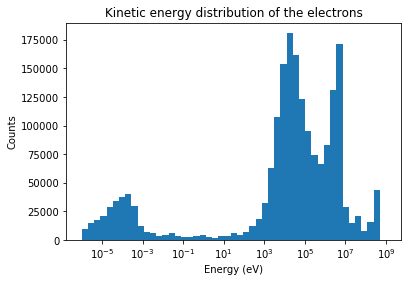

In [2]:
# Calculate the elctron energy and temperature
# This is non-equilibrium so temperature doesn't really make sense
data = load.get_species_data(fileName, species)
attrs = load.get_species_attrs(fileName, species)
mesh = load.get_mesh(path, simName)
weights = analyze.get_weights(data)
energy = analyze.get_ptc_energy(data, mass)
KE = energy - mass

plt.hist(KE, bins=np.logspace(-6, 9, 50), weights=weights)
plt.title('Kinetic energy distribution of the electrons')
plt.xlabel('Energy (eV)')
plt.ylabel('Counts')
plt.gca().set_xscale("log")
plt.show()

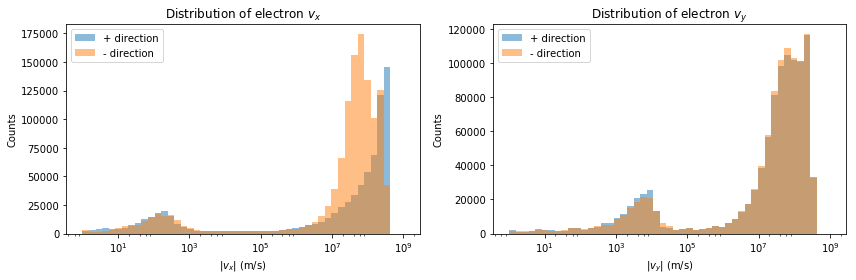

In [3]:
# Calculate the temperature 
gamma = analyze.get_ptc_gamma(data)
vx = analyze.get_ux(data) / gamma
vy = analyze.get_uy(data) / gamma

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.hist(vx, bins=np.logspace(0, 9, 50), weights=weights, alpha=0.5, label='+ direction')
plt.hist(-vx, bins=np.logspace(0, 9, 50), weights=weights, alpha=0.5, label='- direction')
plt.title(r'Distribution of electron $v_x$')
plt.xlabel(r'$|v_x|$ (m/s)')
plt.ylabel('Counts')
plt.gca().set_xscale("log")
plt.legend()

plt.subplot(122)
plt.hist(vy, bins=np.logspace(0, 9, 50), weights=weights, alpha=0.5, label='+ direction')
plt.hist(-vy, bins=np.logspace(0, 9, 50), weights=weights, alpha=0.5, label='- direction')
plt.title(r'Distribution of electron $v_y$')
plt.xlabel(r'$|v_y|$ (m/s)')
plt.ylabel('Counts')
plt.gca().set_xscale("log")
plt.legend()

plt.tight_layout()
plt.show()

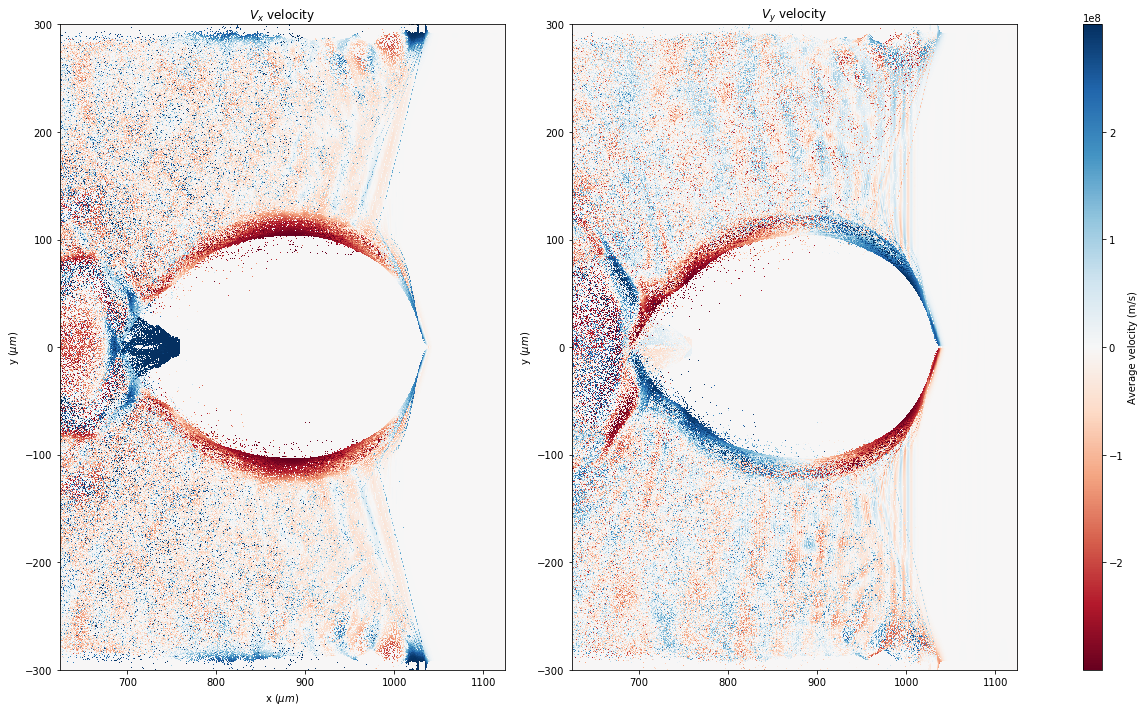

In [4]:
# We need to be able to visualize where this is occuring on the grid
# I don't know who wrote this but this is an incredibly slow way to do this
Nx = mesh['numCells'][0]
Ny = mesh['numCells'][1]
dx = mesh['cellSize'][0]
dy = mesh['cellSize'][1]
XStart = attrs['lowerBounds'][0]
YStart = attrs['lowerBounds'][1]
XEnd = attrs['upperBounds'][0]
YEnd = attrs['upperBounds'][1]
x = analyze.get_x(data) - XStart
y = analyze.get_y(data) - YStart
N = len(x)
vxCell = np.zeros((Nx, Ny))
vyCell = np.zeros((Nx, Ny))
numPtcs = np.zeros((Nx, Ny)) # Strictly speaking, sum of weights
for i in range(N):
    indX = int(x[i] / dx)
    indY = int(y[i] / dy)
    vxCell[indX, indY] += vx[i]*weights[i]
    vyCell[indX, indY] += vy[i]*weights[i]
    numPtcs[indX, indY] += weights[i]

sel = numPtcs != 0.0
vxCell[sel] /= numPtcs[sel]
vyCell[sel] /= numPtcs[sel]

plotVx = np.flipud(np.transpose(vxCell))
plotVy = np.flipud(np.transpose(vyCell))
extent = np.array([XStart, XEnd, YStart, YEnd])*1e6
fig = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(1, 3, width_ratios=[24, 24, 1])

plt.subplot(gs[0, 0])
plt.imshow(plotVx, aspect='auto', extent=extent, cmap='RdBu')
plt.title(r'$V_x$ velocity')
plt.xlabel(r'x ($\mu m$)')
plt.ylabel(r'y ($\mu m$)')

plt.subplot(gs[0, 1])
plt.imshow(plotVy, aspect='auto', extent=extent, cmap='RdBu')
plt.title(r'$V_y$ velocity')
plt.ylabel(r'y ($\mu m$)')

colorAx = plt.subplot(gs[0, 2])
cb = plt.colorbar(cax=colorAx)
cb.set_label('Average velocity (m/s)')
plt.tight_layout()
plt.show()

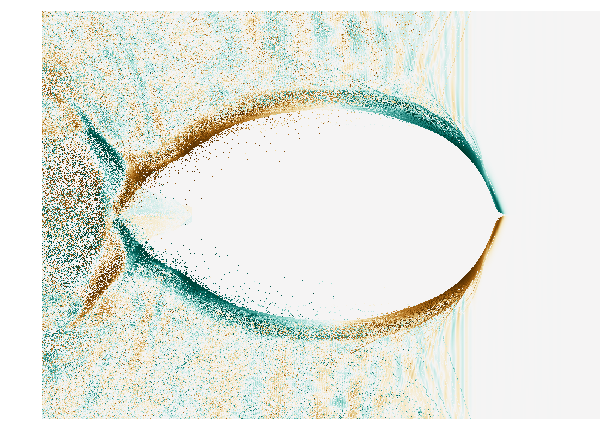

In [29]:
plt.figure(figsize=(10, 7.5))
plt.imshow(plotVy, aspect='auto', extent=extent, cmap='BrBG')
plt.axis('off')
plt.ylim([-200, 200])
plt.savefig('wakefield.svg')
plt.show()